### Positional Encoding

Sean:

- $ X \in \mathbb{R}^{l \times d} $ una secuencia de $s$ vectores de embbedding de dimension $d$.

$$ X = 

\begin{bmatrix}

    \vec{x}^1 \\
    \vec{x}^2 \\
    \vdots \\
    \vec{x}^l

\end{bmatrix}


= \begin{bmatrix}

    x^1_1 & x^1_2 & \cdots & x^1_d \\
    x^2_1 & x^2_2 & \cdots & x^2_d \\
    \vdots & \vdots & \ddots & \vdots \\
    x^l_1 & x^l_2 & \cdots & x^l_d

\end{bmatrix} $$

Con $ \vec{x}^t \in \mathbb{R}^d $ es el vector de embbedding de la palabra en la fila $t$ (posición del vector en la secuencia).

El modelo transformer no captura información sobre la posición de los vectores de embbedding en la secuencia, por lo que se necesita agregarles esta información antes de que la secuencia ingrese al modelo, lo cual se logra, sumandole a cada uno, otro vector con información sobre su posición $ \vec{p} ^ t $. 
$$ \vec{p}^t = \begin{bmatrix} p^t_1 & p^t_2 & \cdots p^t_d \end{bmatrix} $$ 

El paper "Attention is all you need" propone la función de codificacion posicional $ \text{P}: \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}^d $ como:

$$
\text{P}(t, s)  = 

\begin{cases} 
    \sin(\omega_k t) & \text{si } s = 2k \\
    \cos(\omega_k t) & \text{si } s = 2k + 1
\end{cases}
$$

Con las "frecuencias" definidas por $$ \omega_k = \frac{1}{N ^ {2 k /d}} = \exp(-\frac{2k}{d}\log(N))$$ 

Donde $N$ es una constante.

La matrix de codificación posicional $ P \in \mathbb{R}^{l \times d} $ entonces sera:

$$ P = \begin{bmatrix}

    0 & 1 & 0 & 1 & \cdots & 0 & 1 \\
    \sin(\omega_1) & \cos(\omega_1) & \sin(\omega_2) & \cos(\omega_2) & \cdots & \sin(\omega_{d/2}) & \cos(\omega_{d/2}) \\
    \sin(\omega_1 2) & \cos(\omega_1 2) & \sin(\omega_2 2) & \cos(\omega_2 2) & \cdots & \sin(\omega_{d/2} 2) & \cos(\omega_{d/2} 2) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    \sin(\omega_1 (l-1)) & \cos(\omega_1 (l-1)) & \sin(\omega_2 (l-1)) & \cos(\omega_2 (l-1)) & \cdots & \sin(\omega_{d/2} (l-1)) & \cos(\omega_{d/2} (l-1))
\end{bmatrix} $$

De modo que en una primera instancia:

$$ X := X + P $$


/tmp/ipykernel_131044/2760309825.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


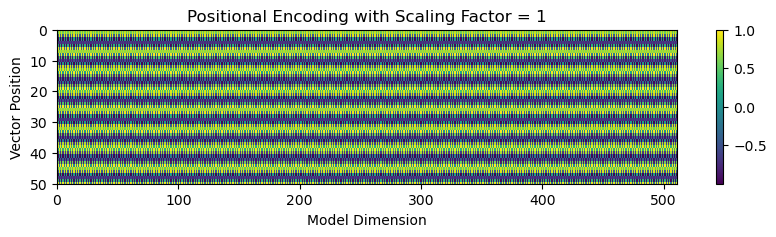

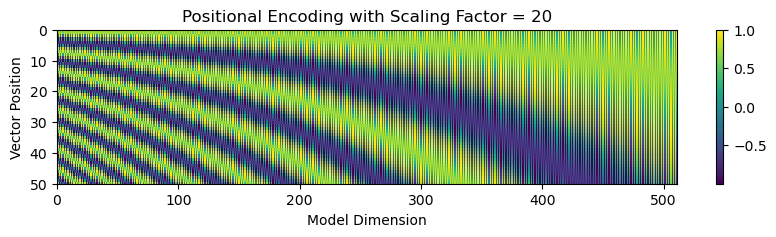

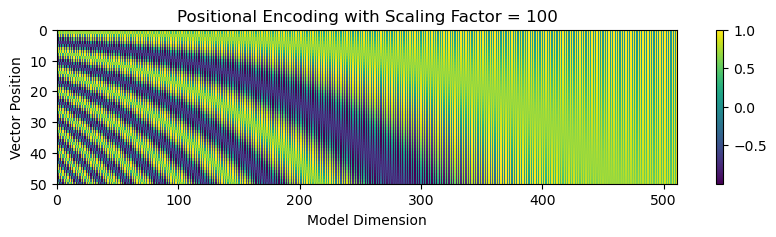

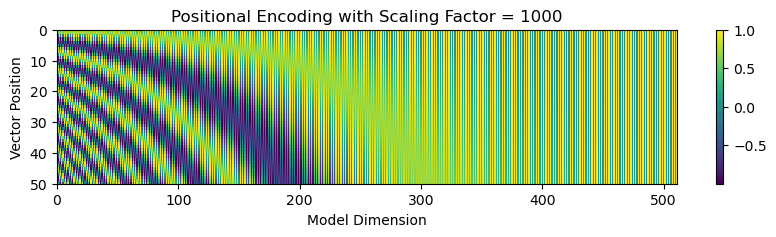

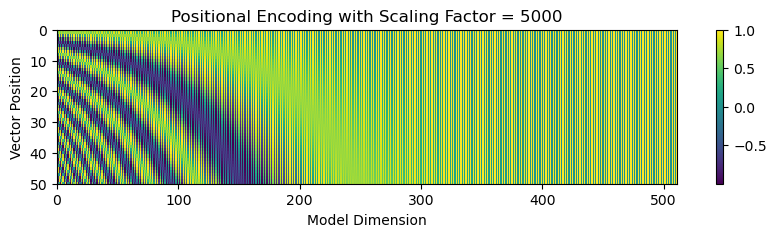

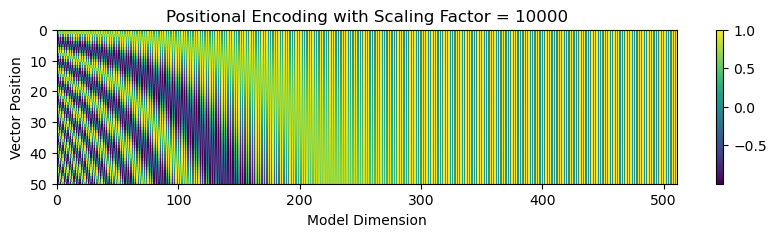

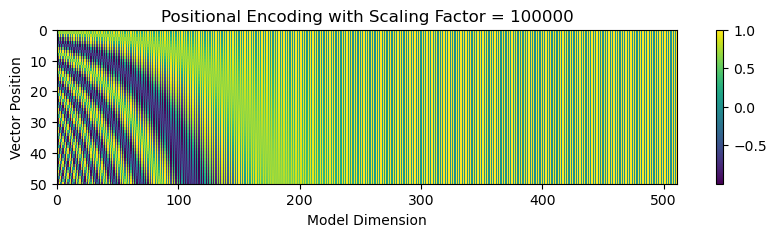

In [52]:
from numpy import exp, log, sin, cos
from numpy import arange, array

from matplotlib.pyplot import figure
from matplotlib.pyplot import Axes

def positional_encoding(sequence: int, model_dimension: int, scaling_factor: int = 10000):
    indexes = array([dimension // 2 + 1 for dimension in range(model_dimension)])
    frequencies = exp(-2*indexes * log(scaling_factor) / model_dimension)
    embeddings = array([
        sin(frequency * sequence) if index % 2 == 1 else 
        cos(frequency * sequence)
        for index, frequency in enumerate(frequencies, start=1)
    ])
    return embeddings


def plot_positonal_encoding(ax: Axes, scaling_factor: int = 10000):
    token_positions = arange(50, -1, -1)
    encoding_dimension = 512

    x = arange(encoding_dimension) 
    y = token_positions
    z = array([positional_encoding(token_position, encoding_dimension, scaling_factor) for token_position in token_positions])

    image = ax.pcolormesh(x, y, z, cmap='viridis')

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.max(), y.min())

    ax.set_xlabel('Model Dimension')
    ax.set_ylabel('Vector Position')
    ax.set_title(f'Positional Encoding with Scaling Factor = {scaling_factor}')

    return image


for scaling_factor in [1, 20, 100, 1000, 5000, 10000, 100000]:
    plot = figure(figsize=(10, 2))
    ax = plot.add_subplot()
    image = plot_positonal_encoding(ax, scaling_factor)
    plot.colorbar(image, ax=ax, orientation='vertical')
    plot.show()

In [58]:
from torch import Tensor
from torch.nn import Module

class PositionalEncoding(Module):
    def __init__(self, sequence_lenght_limit: int, model_dimension: int):
        super().__init__()
        self.positional_embeddings = Tensor([positional_encoding(sequence, model_dimension) for sequence in range(sequence_lenght_limit)])

    def forward(self, input: Tensor) -> Tensor:
        input = input + self.positional_embeddings[:,:input.size(1)]
        return input

### Self-Attention (Mecanismo de atención)

El concepto de key/value/query es análogo a los sistemas de busqueda. Por ejemplo, cuando busca videos en Youtube, el motor de búsqueda asigna su consulta (query) (texto en la barra de búsqueda) contra un conjunto de claves (keys) (título del video, descripción, etc.) asociadas con videos candidatos en su base de datos, y luego le presenta los con mayor coincidencia (values).

Para los modelos de lenguage, los key/value/query generalemente provienen de la misma fuente, es por esto que se denomina mecanismo de self-attention (atencion propia).

La entrada consta de consultas y claves de dimensión $d_k$, y valores de dimensión $d_v$.

$$ \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

In [ ]:
import math
from torch import Tensor
from torch.nn.functional import softmax

def attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:        
    variance = math.sqrt(key.size(-1))
    score = query @ key.transpose(-2, -1) / variance
    return softmax(score, dim=-1) @ value

### Multihead attention

Sean:

- $W^Q \in \mathbb{R}^{d \times d_q}$
- $W^K \in \mathbb{R}^{d \times d_k}$
- $W^V \in \mathbb{R}^{d \times d_v}$

Con $d_q = d_k$. Dado un tensor $X \in \mathbb{R}^{l \times d}$, decimos que los productos:

- $X W^Q \in \mathbb{R}^{l \times d_k} $
- $X W^K  \in \mathbb{R}^{l \times d_k} $
- $X W^VX  \in \mathbb{R}^{l \times d_v}  $ 

Son las proyecciones del tensor $X$ en los espacios de consultas, claves y valores respectivamente. Podemos entonces definir el mecanismo de atención multi-cabezas como:

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \cdots, \text{head}_h) W^O $$
$$ \text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i) $$

Con $Q W^Q_i$, $K W^K_i$ y $V W^V_i$ son las proyecciones de los tensores $Q$, $K$ y $V$ en los espacios de consulta, clave y valor respectivamente, para una cabeza $\text{head}_i$, y $W^O$ es otra transformación que se aplica al resultado de concatenar las salidas de cada cabeza. Estas transformaciones son las encargadas de generar las distintas "cabezas" a partir de las consultas, claves y valores originales.

Aunque en la definicion de la capa del mecanismo de atencion multi-cabezas se generan distintas vistas para los tensores de entrada $Q$, $K$ y $V$, en la practica, es mas sencillo y eficiente computacionalmente, generar una sola proyección de estos tensores y luego dividirlos en $h$ partes, de modo que se generan las matrices $Q_i$, $K_i$ y $V_i$ para cada cabeza $i$. Esto puede lograrse de la siguiente manera:


Dada una proyección $ P \in \mathbb{R} ^ { l \times d } $, ya sea $P = W^Q Q, W^K K$ ó $W^V V$ podemos dividir cada fila de $P$ en $h$ partes de dimension $d/h$ y luego agrupar los vectores de cada parte en una matriz de dimension $l \times d/h$ en un mismo tensor agregando una dimension de la siguiente manera:

$$ P = \begin{bmatrix} 

    p^1_1 & p^1_2 & \cdots & p^1_d  \\
    p^2_1 & p^2_2 & \cdots & p^2_d   \\
    \vdots & \vdots & \ddots  & \vdots \\
    p^l_1 & p^l_2 & \cdots & p^l_d  \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^1_{d\frac{(h-1)}{h}+1} &  \cdots & p^1_d  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^l_1 & \cdots & p^l_{d/h}  \\

        
    \vdots & \ddots  & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & p^1_2 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^l_1 & p^l_2 & \cdots & p^l_{d/h}  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^1_{d\frac{(h-1)}{h}+1}  & \cdots & p^1_d  \\

        
    \vdots & \vdots & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} 

$$ 





De modo que definir $h$ proyectores $W^P$ de dimension $d/h \times d_p$ y multiplicarlos por los tensores de entrada, es igual a definir un solo tensor $W^P$ de dimension $d \times d_p$ con el cual se genera una sola proyeccion $P$, a partir del tensor de entrada, y luego realizar el "split" de la dimension $d$ en $h$ partes de dimension $d/h$.

De modo que el mecanismo de attención propia queda, para todas las cabezas como:

$$ \text{Attention}(Q, K, V) = \text{Softmax}(

\begin{bmatrix} 

    \begin{bmatrix} 

        q^1_1 & q^1_2 & \cdots & q^1_{d_k/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        q^l_1 & q^l_2 & \cdots & q^l_{d_k/h}  \\

    \end{bmatrix} 
    
    \begin{bmatrix} 

        k^1_1 & k^1_2 & \cdots & k^l_1  \\

        \vdots & \vdots & \ddots  & \vdots \\

        k^1_{d_k/h} & k^l_2 & \cdots & k^l_{d_k/h}  \\

    \end{bmatrix} \\ 
    
    \vdots \\ 
    
    \begin{bmatrix} 

        q^1_{d_k\frac{(h-1)}{h}+1} & \cdots & q^1_{d_k}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        q^l_{d_k\frac{(h-1)}{h}+1} & \cdots & q^l_{d_k}  \\

    \end{bmatrix}

    \begin{bmatrix} 

        k^1_{d_k\frac{(h-1)}{h}+1} & \cdots &  k^l_{d_k\frac{(h-1)}{h}+1}  \\

        \vdots & \vdots & \vdots\\

        k^1_{d_k} & \cdots & k^l_{d_k}  \\

    \end{bmatrix} \\

\end{bmatrix} 

    / \sqrt{d_k/h} 
    
)

\begin{bmatrix} 

    \begin{bmatrix} 

        v^1_1 & v^1_2 & \cdots & v^1_{d_v/h}  \\
        \vdots & \vdots & \ddots  & \vdots \\
        v^l_1 & v^l_2 & \cdots & v^l_{d_v/h}  \\

    \end{bmatrix} \\

    \vdots \\

    \begin{bmatrix} 

        v^1_1 & v^1_2 & \cdots & v^1_{d_v/h}  \\
        \vdots & \vdots & \ddots  & \vdots \\
        v^l_1 & v^l_2 & \cdots & v^l_{d_v/h}  \\

    \end{bmatrix}

\end{bmatrix} $$ 

En donde cada matriz dentro de los tensores corresponde a una cabeza de atención. El resultado de la función de atención es un tensor de dimension $h \times l \times l$. El cual se multiplica por el tensor $V$ dando como resultado un tensor de dimension $h \times l \times d_v/h$.

La concatenación de las salidas de cada cabeza se realiza en la dimension $d_v/h$ y es el proceso inverso al descripto para el del "split" de modo que el resultado final es un tensor de dimension $l \times d_v$.

Finalmente, el output se multiplica por la matriz $W^O \in \mathbb{R}^{d_v \times d}$ para obtener el resultado final de la capa de atención multi-cabeza, el cual tendra dimension $l \times d$.


In [3]:
from torch import Tensor
from torch.nn import Module
from torch.nn import Linear

def split(sequence: Tensor, number_of_heads: int) -> Tensor:
    batch_size, sequence_length, model_dimension = sequence.size()
    sequence = sequence.view(batch_size, sequence_length, model_dimension // number_of_heads, number_of_heads)
    sequence = sequence.transpose(1, 2).contiguous()
    return sequence

def concat(sequence: Tensor) -> Tensor:
    batch_size, sequence_lenght, heads_dimension, number_of_heads = sequence.size()
    sequence = sequence.transpose(1, 2).contiguous()
    sequence = sequence.view(batch_size, sequence_lenght, heads_dimension* number_of_heads)
    return sequence

class MultiHead(Module):
    def __init__(self, model_dimension: int, key_dimension: int, value_dimension: int, number_of_heads):
        super().__init__()
        self.number_of_heads = number_of_heads
        self.query_projection = Linear(key_dimension, model_dimension, bias=False)
        self.key_projection = Linear(key_dimension, model_dimension, bias=False)
        self.value_projection = Linear(value_dimension, model_dimension, bias=False)
        self.output_projection = Linear(model_dimension, value_dimension)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        query, key, value = self.query_projection(query), self.key_projection(key), self.value_projection(value)
        query, key, value = split(query, self.number_of_heads), split(key, self.number_of_heads), split(value, self.number_of_heads)
        heads = attention(query, key, value)
        heads = concat(heads)
        return self.output_projection(heads)

Luego se define la normalización por capa o "layer normalization", la cual se describe en el paper https://arxiv.org/pdf/1607.06450, el cual consiste en normalizar los valores de un tensor $X \in \mathbb{R}^{l \times d}$ a lo largo de la dimension $d$ para cada vector de la secuencia, de la siguiente manera:

$$ \text{LayerNorm}(X) = \gamma \frac{X - \mu}{\sqrt{\text{Var}(X) + \epsilon}} + \beta $$

En donde $\mu$ y $\text{Var}(X)$ son la media y la varianza de los valores de $X$ a lo largo de la dimension $d$ respectivamente, y $\gamma$ y $\beta$ son parametros que se aprenden durante el entrenamiento.


In [4]:
from torch import zeros, ones
from torch import sqrt
from torch import Tensor
from torch.nn import Parameter
from torch.nn import Module

class LayerNormalization(Module):
    def __init__(self, model_dimension: int, epsilon: float = 1e-12):
        super().__init__()
        self.gamma = Parameter(data=ones(model_dimension))
        self.beta = Parameter(data=zeros(model_dimension))
        self.epsilon = epsilon

    def forward(self, input: Tensor) -> Tensor:
        mean = input.mean(dim=-1, keepdim=True)
        variance = input.var(dim=-1, unbiased=True, keepdim=True)
        return self.gamma * ((input - mean) / sqrt(variance + self.epsilon)) + self.beta

La ultima pieza importante en el modelo transformer es la capa feedforward, la cual consiste simplemente en un autoencoder con una capa oculta y una función de activación. 

In [ ]:
from torch import Tensor
from torch.nn import Module, Linear, ReLU, Sequential, Dropout

class FeedForward(Module):
    def __init__(self, model_dimension: int, hidden_dimension: int, dropout_rate: float = 0.2):
        super().__init__()
        self.layers = Sequential(
            Linear(model_dimension, hidden_dimension),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dimension, model_dimension)
        )
    
    def forward(self, input: Tensor) -> Tensor:
        return self.layers(input)

In [ ]:
from torch import Tensor
from torch.nn import Module

class Encoder(Module):
    def __init__(self, model_dimension: int):
        super().__init__()
        self.multihead_attention = MultiHead(model_dimension, ...)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.feed_forward_network = FeedForward(model_dimension)
        self.second_layer_normalization = LayerNormalization(model_dimension)

    def forward(self, sequence: Tensor) -> Tensor:
        sequence = self.multihead_attention(sequence, sequence, sequence) + sequence
        sequence = self.first_layer_normalization(sequence)
        
        sequence = self.feed_forward_network(sequence) + sequence
        sequence = self.second_layer_normalization(sequence)
        return sequence
    
    
class Decoder(Module):
    def __init__(self, model_dimension: int):
        super().__init__()
        self.first_multihead_attention = MultiHead(model_dimension, ...)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.second_multihead_attention = MultiHead(model_dimension, ...)
        self.second_layer_normalization = LayerNormalization(model_dimension)
        
        self.feed_forward_network = FeedForward(model_dimension)
        self.third_layer_normalization = LayerNormalization(model_dimension)

    def forward(self, sequence: Tensor, prior: Tensor) -> Tensor:
        prior = self.first_multihead_attention(prior, prior, prior) + prior
        prior = self.first_layer_normalization(prior)

        sequence = self.second_multihead_attention(sequence, sequence, prior) + prior
        sequence = self.second_layer_normalization(sequence)

        sequence = self.feed_forward_network(sequence) + sequence
        sequence = self.third_layer_normalization(sequence)
        return sequence